In [1]:
import pandas as pd
import numpy as np
from util.data_management import concate_data, load_data_raw, display_data, data_to_fft, data_adjust_scale, data_reshape_for_train, data_split_to_chunk
from util.data_generator_AE import DataGenerator
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline 
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from sklearn import metrics
from easydict import EasyDict

In [2]:
from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
  except RuntimeError as e:
    # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
    print(e)

In [3]:
args = EasyDict({
    'dir_path' : r"D:\Anomaly-Dataset", ## 1: C:\Users\VIP444\Documents\Anomaly-Dataset, 2: D:\Anomaly-Dataset\sar400_vibration_data
    'is_normal' : True,
    'is_train' : True,
    'stop_idx' : 2,
    'data_scale_fit' : True,
    'data_scale_trans' : False,
    'batch_size' : 512,
    'split' : (0.9, 0.1),
    'is_cache' : True,
    'is_normalize' : False,
    'is_lstm' : True
})

In [4]:
train_dataset = DataGenerator(
    dataset_path=args.dir_path,
    train_mode='Train',
    batch_size=args.batch_size,
    split=args.split,
    is_train=args.is_train,
    is_cache=args.is_cache,
    is_normalize=args.is_normalize,
    is_lstm=args.is_lstm
)

validation_dataset = DataGenerator(
    dataset_path=args.dir_path,
    train_mode='Validation',
    batch_size=args.batch_size,
    split=args.split,
    is_train=args.is_train,
    is_cache=args.is_cache,
    is_normalize=args.is_normalize,
    is_lstm=args.is_lstm
)

test_dataset = DataGenerator(
    dataset_path=args.dir_path,
    train_mode='Test',
    batch_size=args.batch_size,
    split=args.split,
    is_train=False,
    is_cache=args.is_cache,
    is_normalize=args.is_normalize,
    is_lstm=args.is_lstm
)

In [5]:
print(len(train_dataset.data_paths))
print(len(validation_dataset.data_paths))
print(len(test_dataset.data_paths))

7034
782
4276


In [ ]:
train_data_0, train_data_1, train_data_2, train_data_3, validation_data_0, validation_data_1, validation_data_2, validation_data_3 = load_data_raw(
    dir_path=args.dir_path, 
    is_normal=args.is_normal, 
    is_train=args.is_train, 
    stop_idx=args.stop_idx
    )

test_data_0, test_data_1, test_data_2, test_data_3 = load_data_raw(
    dir_path=args.dir_path,
    is_normal=False,
    is_train=False,
    stop_idx=args.stop_idx
)

display_data(train_data_0, validation_data_0, test_data_0)

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

train_data_0 = train_data_0[:len(test_data_0)]

x = pd.DataFrame({
    'x1': train_data_0.squeeze(-1),
    'x2': test_data_0.squeeze(-1),
    })

scaler = RobustScaler()
robust_df = scaler.fit_transform(x)
robust_df = pd.DataFrame(robust_df, columns =['x1', 'x2'])

scaler = StandardScaler()
standard_df = scaler.fit_transform(x)
standard_df = pd.DataFrame(standard_df, columns =['x1', 'x2'])

scaler = MinMaxScaler()
minmax_df = scaler.fit_transform(x)
minmax_df = pd.DataFrame(minmax_df, columns =['x1', 'x2'])

fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols = 4, figsize =(20, 5))
ax1.set_title('Before Scaling')

sns.kdeplot(x['x1'], ax = ax1, color ='r')
sns.kdeplot(x['x2'], ax = ax1, color ='b')
ax2.set_title('Robust Scaling')

sns.kdeplot(robust_df['x1'], ax = ax2, color ='red')
sns.kdeplot(robust_df['x2'], ax = ax2, color ='blue')
ax3.set_title('Standard Scaling')

sns.kdeplot(standard_df['x1'], ax = ax3, color ='black')
sns.kdeplot(standard_df['x2'], ax = ax3, color ='g')
ax4.set_title('Min-Max Scaling')

sns.kdeplot(minmax_df['x1'], ax = ax4, color ='black')
sns.kdeplot(minmax_df['x2'], ax = ax4, color ='g')
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer
from sklearn.pipeline import Pipeline

pipeline = Pipeline([('Scaler', StandardScaler())])

X_train_0 = data_adjust_scale(pipeline, train_data_0, args.data_scale_fit)
X_train_1 = data_adjust_scale(pipeline, train_data_1, args.data_scale_trans)
X_train_2 = data_adjust_scale(pipeline, train_data_2, args.data_scale_trans)
X_train_3 = data_adjust_scale(pipeline, train_data_3, args.data_scale_trans)

X_validation_0 = data_adjust_scale(pipeline, validation_data_0, args.data_scale_trans)
X_validation_1 = data_adjust_scale(pipeline, validation_data_1, args.data_scale_trans)
X_validation_2 = data_adjust_scale(pipeline, validation_data_2, args.data_scale_trans)
X_validation_3 = data_adjust_scale(pipeline, validation_data_3, args.data_scale_trans)

X_test_0 = data_adjust_scale(pipeline, test_data_0, args.data_scale_trans)
X_test_1 = data_adjust_scale(pipeline, test_data_1, args.data_scale_trans)
X_test_2 = data_adjust_scale(pipeline, test_data_2, args.data_scale_trans)
X_test_3 = data_adjust_scale(pipeline, test_data_3, args.data_scale_trans)

display_data(X_train_0, X_validation_0, X_test_0)

In [ ]:
X_train = concate_data((X_train_0, X_train_1, X_train_2, X_train_3), 1)
X_validation = concate_data((X_validation_0, X_validation_1, X_validation_2, X_validation_3), 1)
X_test = concate_data((X_test_0, X_test_1, X_test_2, X_test_3), 1)

print(X_train.shape)
print(X_validation.shape)
print(X_test.shape)

X_train = data_reshape_for_train(X_train_0, X_train_1, X_train_2, X_train_3)
X_validation = data_reshape_for_train(X_validation_0, X_validation_1, X_validation_2, X_validation_3)
X_test = data_reshape_for_train(X_test_0, X_test_1, X_test_2, X_test_3)

print(X_train.shape)
print(X_validation.shape)
print(X_test.shape)

In [12]:
from models.ae_LSTM import autoencoder_model
# from models.ae_Dense import autoencoder_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber

if args.is_lstm:
    input_shape = (1, 4)
else:
    input_shape = (4, )

model = autoencoder_model(input_shape)
model.compile(optimizer=Adam(learning_rate=1e-3), loss=Huber(), metrics=['mae'])
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1, 4)]            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 1, 64)             17664     
_________________________________________________________________
lstm_9 (LSTM)                (None, 32)                12416     
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 1, 32)             0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 1, 32)             8320      
_________________________________________________________________
lstm_11 (LSTM)               (None, 1, 64)             24832     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 1, 4)              260 

In [13]:
epochs = 200

checkpoint_path = "model/checkpoint.pt"

callbacks = [
    # EarlyStopping(monitor='val_mae', patience=7, verbose=1),
    ModelCheckpoint(filepath=checkpoint_path, monitor='val_mae', verbose=1, save_best_only=True, save_weights_only=True),
    ReduceLROnPlateau(monitor='val_mae', factor=0.8, patience=6,verbose=1,min_lr=1e-3 * 1e-1),
    CSVLogger('./train_log.csv', separator=',', append=True),
    ]

# history = model.fit(X_train, X_train, epochs=epochs, batch_size=args.batch_size, callbacks=callbacks, validation_data=(X_validation, X_validation)).history
history = model.fit(train_dataset, validation_data=(validation_dataset), epochs=epochs, batch_size=args.batch_size, callbacks=callbacks).history

model.load_weights(checkpoint_path)
model.save("model/model_loss_test.h5")

Epoch 1/200
13/13 [==============================] - 2s 48ms/step - loss: 1.0395 - mae: 1.4401 - val_loss: 1.3687 - val_mae: 1.7858

Epoch 00001: val_mae improved from inf to 1.78582, saving model to model\checkpoint.pt
Epoch 2/200
13/13 [==============================] - 0s 24ms/step - loss: 1.0239 - mae: 1.4193 - val_loss: 1.3493 - val_mae: 1.7614

Epoch 00002: val_mae improved from 1.78582 to 1.76136, saving model to model\checkpoint.pt
Epoch 3/200
13/13 [==============================] - 0s 20ms/step - loss: 1.0018 - mae: 1.3904 - val_loss: 1.3151 - val_mae: 1.7192

Epoch 00003: val_mae improved from 1.76136 to 1.71922, saving model to model\checkpoint.pt
Epoch 4/200
13/13 [==============================] - 0s 20ms/step - loss: 0.9553 - mae: 1.3321 - val_loss: 1.2010 - val_mae: 1.5842

Epoch 00004: val_mae improved from 1.71922 to 1.58422, saving model to model\checkpoint.pt
Epoch 5/200
13/13 [==============================] - 0s 20ms/step - loss: 0.7633 - mae: 1.1059 - val_loss: 0

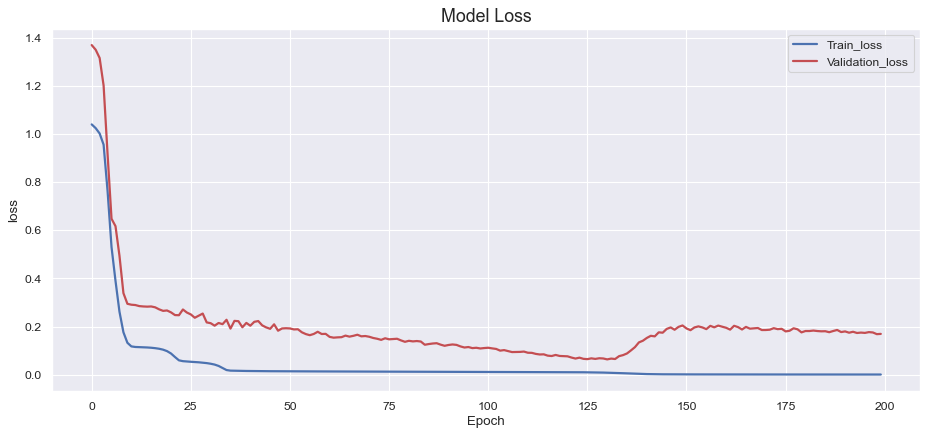

In [54]:
import matplotlib.pyplot as plt
%matplotlib inline 

fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train_loss', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation_loss', linewidth=2)
ax.set_title('Model Loss', fontsize=16)
ax.set_ylabel('loss')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

In [ ]:
loss = model.evaluate(test_dataset, verbose=1)
print(loss)

In [15]:
predict = model.predict(test_dataset)
print(predict.shape)

(4096, 1, 4)


In [17]:
predict_val = model.predict(validation_dataset)
print(predict_val.shape)

(512, 1, 4)


In [19]:
predict = predict.reshape(predict.shape[0], predict.shape[2])
predict_val = predict_val.reshape(predict_val.shape[0], predict_val.shape[2])

In [20]:
print(predict.shape)
print(predict_val.shape)

(4096, 4)
(512, 4)


In [34]:
validation_data = validation_dataset.cache[0][0]
validation_data = validation_data.reshape(validation_data.shape[0], validation_data.shape[2])
print(validation_data.shape)

(512, 4)


1.0
1.0
0.17779562164104545


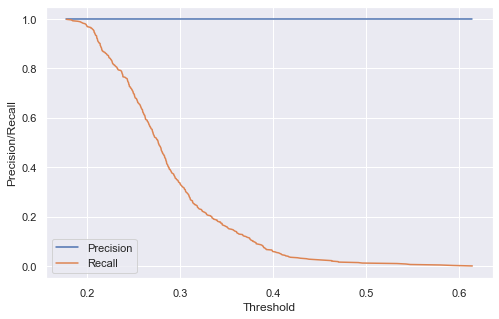

In [45]:
# mae = np.mean(np.power(validation_data - predict_val, 2), axis=1)
mae = np.mean(np.abs(validation_data - predict_val), axis=1)

y_valid = np.ones(len(validation_data))

error_df = pd.DataFrame({'Reconstruction_error':mae, 'True_class': y_valid})

precision_rt, recall_rt, threshold_rt = metrics.precision_recall_curve(error_df['True_class'], error_df['Reconstruction_error'])

best_cnt_dic = abs(precision_rt - recall_rt)
threshold = threshold_rt[np.argmin(best_cnt_dic)]

print(precision_rt[np.argmin(best_cnt_dic)])
print(recall_rt[np.argmin(best_cnt_dic)])
print(threshold)

plt.figure(figsize=(8,5))
plt.plot(threshold_rt, precision_rt[1:], label='Precision')
plt.plot(threshold_rt, recall_rt[1:], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

In [ ]:
model = tf.keras.models.load_model('model/model_loss_test.h5')

X_pred = model.predict(X_train)

X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2]) 
X_pred = pd.DataFrame(X_pred)

Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2]) 

scored = pd.DataFrame()
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis=1)
# scored['Loss_mae'] = np.mean(X_pred-Xtrain, axis=1) 

Threshold = 0.017

plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
plt.xlim([0,1])
sns.distplot(scored['Loss_mae'], kde= True, color = 'blue')

In [52]:
X_pred = pd.DataFrame(predict)

scored = pd.DataFrame()
scored['Loss_mae'] = np.mean(np.abs(X_pred), axis=1)
scored['Threshold'] = threshold*2
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
print(scored)

scored.to_csv('./test_log.csv', sep=',')

      Loss_mae  Threshold  Anomaly
0     7.677608   0.355591     True
1     7.413066   0.355591     True
2     7.877768   0.355591     True
3     7.689849   0.355591     True
4     6.997663   0.355591     True
...        ...        ...      ...
4091  6.016593   0.355591     True
4092  6.173636   0.355591     True
4093  6.350965   0.355591     True
4094  6.216855   0.355591     True
4095  6.222941   0.355591     True

[4096 rows x 3 columns]


In [55]:
X_pred

,0,1,2,3
0,6.887468,7.766244,7.355838,8.700882
1,6.567360,7.351952,7.238588,8.494366
2,7.108690,8.104434,7.465833,8.832117
3,7.030588,7.702415,7.265896,8.760498
4,6.301540,6.551076,6.871746,8.266291
...,...,...,...,...
4091,3.734769,6.517411,7.404243,6.409949
4092,3.887559,6.651738,7.526668,6.628582
4093,4.520319,6.619460,7.294897,6.969188
4094,3.973741,6.710974,7.510346,6.672358


In [53]:
X_pred_val = pd.DataFrame(predict_val)

scored_val = pd.DataFrame()
scored_val['Loss_mae'] = np.mean(np.abs(X_pred_val-validation_data), axis=1)
scored_val['Threshold'] = threshold*2
scored_val['Anomaly'] = scored_val['Loss_mae'] > scored_val['Threshold']
print(scored_val)
scored_val.to_csv('./validation_log.csv', sep=',')

     Loss_mae  Threshold  Anomaly
0    0.298003   0.355591    False
1    0.286028   0.355591    False
2    0.252952   0.355591    False
3    0.392858   0.355591     True
4    0.399762   0.355591     True
..        ...        ...      ...
507  0.208986   0.355591    False
508  0.259600   0.355591    False
509  0.310010   0.355591    False
510  0.270270   0.355591    False
511  0.248720   0.355591    False

[512 rows x 3 columns]


In [ ]:
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred)

Threshold = 0.3

scored = pd.DataFrame()
Xtest = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred), axis=1)
scored['Threshold'] = Threshold
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
print(scored)

scored.to_csv('./train_log.csv', sep=',')